In [1]:
from google.colab import drive
drive.mount('/content/drive')

root = '/content/drive/My Drive/surely_not_sarcasm_data/'

Mounted at /content/drive


In [ ]:
!pip install contractions
!cp -r '$root/utils' .

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import keras
import pickle
import nltk

from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from nltk.sentiment import SentimentIntensityAnalyzer

from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Attention, MultiHeadAttention
from tensorflow.keras.layers import Concatenate, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2

from utils.preprocessing import WordEmbeddings
from utils.evaluation import plot_history, evaluate, show_errors

from numpy.linalg import norm

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);

In [4]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# prepare data

In [5]:
data = pickle.load(open(root+'preprocessed_data_all_1705', 'rb'))
df = pd.DataFrame(data).reset_index(drop=True)

In [6]:
X = df[['raw_comment', 'raw_parent', 'comment', 'parent']]
y = df['label'].values

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.1, random_state=42)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((722210, 4), (200615, 4), (80246, 4))

In [9]:
vocab_size = 10000
input_dim = vocab_size + 2 # one for padding, one for oov token

In [10]:
maxlen = int(X_train['comment'].str.split().str.len().quantile(0.9))
maxlen_par = int(X_train['parent'].str.split().str.len().quantile(0.8))

In [11]:
maxlen, maxlen_par

(24, 38)

In [12]:
tokenizer_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen, standardize=None)
tokenizer_layer.adapt(X_train['comment'])

In [ ]:
tokenizer_par_layer = TextVectorization(max_tokens=input_dim, output_sequence_length=maxlen_par, standardize=None)
tokenizer_par_layer.adapt(X_train['parent'])

# some helper functions

In [16]:
def plot_attention_scores(model, X):
    partial_model = keras.Model(inputs=model.input, outputs=model.get_layer('attention').output)
    _, att_scores = partial_model.predict(X)

    if len(X) != 1:
        ylabels = [tokenizer_layer.get_vocabulary()[id] for id in tokenizer_layer(X[0][0]).numpy() if id != 0]
        xlabels = [tokenizer_par_layer.get_vocabulary()[id] for id in tokenizer_par_layer(X[1][0]).numpy() if id !=0]
    else:
        ylabels = [tokenizer_layer.get_vocabulary()[id] for id in tokenizer_layer(X[0]).numpy() if id != 0]
        xlabels = ylabels

    for i in range(att_scores.shape[1]):
        plt.figure(figsize=(16,6))
        sns.heatmap(att_scores[0, i, :len(ylabels), :len(xlabels)], yticklabels=ylabels, xticklabels=xlabels)

In [17]:
def get_emotion_embeddings(emb_matrix, vocab, seed_words):
    length = emb_matrix.shape[1]
    seed_word_vec = WordEmbeddings().get_glove_vectors(tokens=seed_words, vec_len=length, root=root)
    emotion_emb = []

    for i, word in enumerate(vocab):
        word_vec = emb_matrix[i, :]
        if word_vec.any():
            emotion_vec = []
            for seed_word in seed_words:
                emotion_vec.append(cosine_similarity(word_vec, seed_word_vec[seed_word]))
            emotion_emb.append(emotion_vec)
        else:
            emotion_emb.append([0]*len(seed_words))

    return np.array(emotion_emb)

In [18]:
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (norm(vec1)*norm(vec2))

# content-based

In [13]:
vocab_com = tokenizer_layer.get_vocabulary()

In [14]:
vec_len = 100
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, vocab_com, root=root)

coverage: 0.9810


## GRU

In [ ]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6)),
    GRU(100, dropout=0.3),
    Dense(1, activation='sigmoid')
])

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 98s 17ms/step - loss: 0.9457 - bc: 0.5619 - accuracy: 0.7062 - val_loss: 0.6495 - val_bc: 0.5351 - val_accuracy: 0.7287
Epoch 2/50
5643/5643 [==============================] - 93s 17ms/step - loss: 0.6197 - bc: 0.5341 - accuracy: 0.7298 - val_loss: 0.5939 - val_bc: 0.5255 - val_accuracy: 0.7344
Epoch 3/50
5643/5643 [==============================] - 93s 16ms/step - loss: 0.5876 - bc: 0.5240 - accuracy: 0.7369 - val_loss: 0.5779 - val_bc: 0.5186 - val_accuracy: 0.7403
Epoch 4/50
5643/5643 [==============================] - 94s 17ms/step - loss: 0.5755 - bc: 0.5169 - accuracy: 0.7425 - val_loss: 0.5723 - val_bc: 0.5159 - val_accuracy: 0.7425
Epoch 5/50
5643/5643 [==============================] - 93s 16ms/step - loss: 0.5689 - bc: 0.5108 - accuracy: 0.7468 - val_loss: 0.5703 - val_bc: 0.5133 - val_accuracy: 0.7442
Epoch 6/50
5643/5643 [==============================] - 92s 16ms/step - loss: 0.5654 - bc: 0.5062 - accuracy: 0.7496 - v

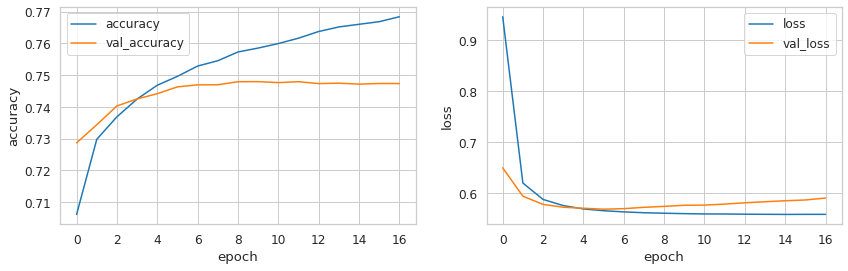

In [ ]:
plot_history(fit)

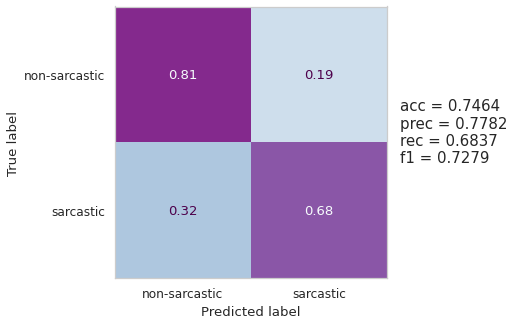

In [ ]:
evaluate(model, X_test['comment'], y_test)

## bi-GRU

In [ ]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6)),
    Bidirectional(GRU(100, dropout=0.3)),
    Dense(1, activation='sigmoid')
])

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy')
es = EarlyStopping(monitor='val_binary_crossentropy', min_delta=1e-5, patience=7, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 190s 23ms/step - loss: 0.9509 - binary_crossentropy: 0.5577 - accuracy: 0.7099 - val_loss: 0.6556 - val_binary_crossentropy: 0.5359 - val_accuracy: 0.7276
Epoch 2/50
5643/5643 [==============================] - 129s 23ms/step - loss: 0.6193 - binary_crossentropy: 0.5297 - accuracy: 0.7333 - val_loss: 0.5958 - val_binary_crossentropy: 0.5241 - val_accuracy: 0.7362
Epoch 3/50
5643/5643 [==============================] - 129s 23ms/step - loss: 0.5850 - binary_crossentropy: 0.5194 - accuracy: 0.7408 - val_loss: 0.5766 - val_binary_crossentropy: 0.5162 - val_accuracy: 0.7423
Epoch 4/50
5643/5643 [==============================] - 128s 23ms/step - loss: 0.5714 - binary_crossentropy: 0.5110 - accuracy: 0.7462 - val_loss: 0.5684 - val_binary_crossentropy: 0.5107 - val_accuracy: 0.7462
Epoch 5/50
5643/5643 [==============================] - 127s 22ms/step - loss: 0.5646 - binary_crossentropy: 0.5051 - accuracy: 0.7507 - val_loss: 0.5678 - 

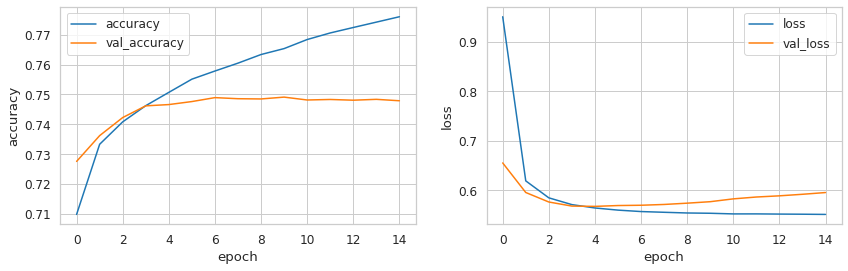

In [ ]:
plot_history(fit)

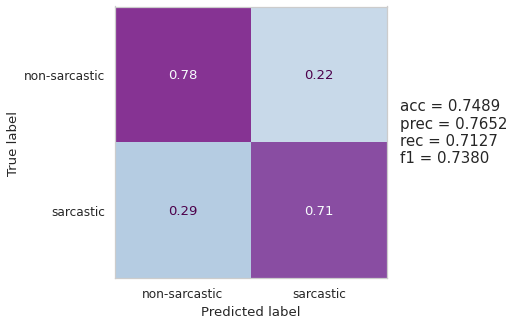

In [ ]:
evaluate(model, X_test['comment'], y_test)

## bi-GRU + auxiliary features

In [ ]:
def get_polarity(column):
    sia = SentimentIntensityAnalyzer()
    polarity = column.apply(lambda x: [sia.polarity_scores(w)['compound'] for w in x.split()])
    min_pol, max_pol = polarity.apply(min), polarity.apply(max)
    abs_diff, mean_pol = polarity.apply(lambda x: abs(min(x)-max(x))), polarity.apply(np.mean)
    return min_pol, max_pol, abs_diff, mean_pol

In [ ]:
def get_auxiliary_features_df(column):
    aux_df = pd.DataFrame()

    all_caps = column.str.count('xxallcapsxx')
    ntokens = (
        column
        .str.replace('xxallcapsxx', '', regex=False)
        .str.replace('xxelongxx', '', regex=False)
        .str.replace('xxnumberxx', '', regex=False)
        .str.replace('xxurlxx', '', regex=False)
        .str.replace('xxuserxx', '', regex=False)
        .str.replace('[^a-zA-Z ]', '', regex=True)
        .str.split().str.len()
    )
    aux_df['all_caps_ratio'] = np.where(ntokens != 0, all_caps/ntokens, 0)

    aux_df['n_exl_marks'] = column.str.count(r'\!')
    aux_df['n_q_marks'] = column.str.count(r'\?')
    aux_df['n_ellipsis'] = column.str.count(r'\.\.\.')
    aux_df['n_quot'] = column.str.count(r'\"')
    aux_df['n_stars'] = column.str.count(r'\*')

    aux_df['n_pos_emo'] = column.str.count(r'\:\)|\;\)|\:D|<3')
    aux_df['n_neg_emo'] = column.str.count(r'\:\(|\:\/|\;\(')

    aux_df['min_pol'], aux_df['max_pol'], aux_df['abs_diff_pol'], aux_df['mean_pol'] = get_polarity(column)
    return aux_df

In [ ]:
aux_df = get_auxiliary_features_df(df['comment'])

In [ ]:
# with open(root+'data/aux_df', 'wb') as file:
#     pickle.dump(aux_df, file)

In [ ]:
# aux_df = pickle.load(open(root+'data/aux_df', 'rb'))

In [ ]:
aux_train, aux_val, aux_y, _ = train_test_split(aux_df, y, stratify=y, test_size=0.2, random_state=42)
aux_train, aux_test, _, _ = train_test_split(aux_train, aux_y, stratify=aux_y, test_size=0.1, random_state=42)

In [ ]:
scaler = StandardScaler()
aux_train = scaler.fit_transform(aux_train)
aux_val = scaler.transform(aux_val)
aux_test = scaler.transform(aux_test)

In [ ]:
train_data = {'comment': X_train['comment'].values, 'aux': aux_train}
val_data = {'comment': X_val['comment'].values, 'aux': aux_val}
test_data = {'comment': X_test['comment'].values, 'aux': aux_test}

In [ ]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
aux_input = Input(shape=(aux_train.shape[1],), name='aux')

tokenize_comment = tokenizer_layer(comment_input)
emb = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))(tokenize_comment)
gru = Bidirectional(GRU(100, dropout=0.3))(emb)

x = Concatenate()([gru, aux_input])
x = BatchNormalization()(x)
x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, aux_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_data, y_train, epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, y_val))

Epoch 1/50
5643/5643 [==============================] - 224s 38ms/step - loss: 1.1268 - bc: 0.5773 - accuracy: 0.6982 - val_loss: 0.6984 - val_bc: 0.5482 - val_accuracy: 0.7220
Epoch 2/50
5643/5643 [==============================] - 211s 37ms/step - loss: 0.6399 - bc: 0.5375 - accuracy: 0.7292 - val_loss: 0.6044 - val_bc: 0.5288 - val_accuracy: 0.7337
Epoch 3/50
5643/5643 [==============================] - 217s 38ms/step - loss: 0.5939 - bc: 0.5263 - accuracy: 0.7373 - val_loss: 0.5792 - val_bc: 0.5185 - val_accuracy: 0.7410
Epoch 4/50
5643/5643 [==============================] - 217s 38ms/step - loss: 0.5781 - bc: 0.5182 - accuracy: 0.7433 - val_loss: 0.5698 - val_bc: 0.5126 - val_accuracy: 0.7454
Epoch 5/50
5643/5643 [==============================] - 216s 38ms/step - loss: 0.5697 - bc: 0.5112 - accuracy: 0.7479 - val_loss: 0.5674 - val_bc: 0.5108 - val_accuracy: 0.7461
Epoch 6/50
5643/5643 [==============================] - 216s 38ms/step - loss: 0.5649 - bc: 0.5054 - accuracy: 0.75

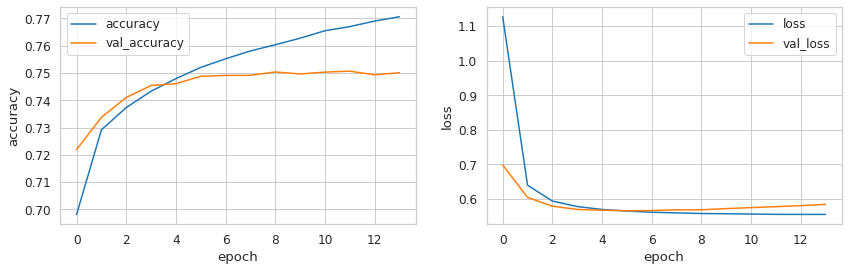

In [ ]:
plot_history(fit)

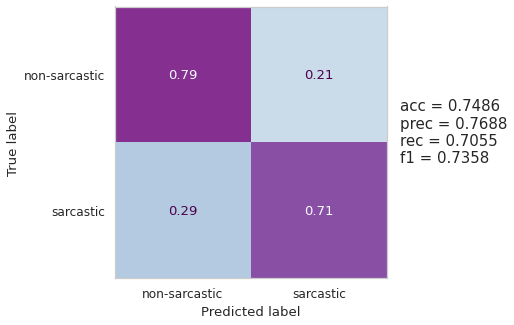

In [ ]:
evaluate(model, test_data, y_test)

## bi-GRU + emotion embeddings

In [ ]:
seed_words = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'good', 'bad']
emotion_emb = get_emotion_embeddings(emb_matrix_comment, vocab_com, seed_words)

In [ ]:
emotion_emb.shape

(10002, 8)

In [ ]:
comment_input = Input(shape=(1,), dtype=tf.string)
tokenize_comment = tokenizer_layer(comment_input)

word_rep = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[emb_matrix_comment], trainable=True,
                  embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))(tokenize_comment)
word_rep = Bidirectional(GRU(100, dropout=0.3))(word_rep)

emo_rep = Embedding(input_dim=input_dim, output_dim=len(seed_words), input_length=maxlen,
                    mask_zero=True, weights=[emotion_emb], trainable=False)(tokenize_comment)
emo_rep = GRU(32, dropout=0.3)(emo_rep)

x = Concatenate()([word_rep, emo_rep])
x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 187s 31ms/step - loss: 1.0594 - binary_crossentropy: 0.5743 - accuracy: 0.6992 - val_loss: 0.6706 - val_binary_crossentropy: 0.5371 - val_accuracy: 0.7265
Epoch 2/50
5643/5643 [==============================] - 170s 30ms/step - loss: 0.6326 - binary_crossentropy: 0.5385 - accuracy: 0.7284 - val_loss: 0.5985 - val_binary_crossentropy: 0.5266 - val_accuracy: 0.7344
Epoch 3/50
5643/5643 [==============================] - 175s 31ms/step - loss: 0.5921 - binary_crossentropy: 0.5270 - accuracy: 0.7369 - val_loss: 0.5809 - val_binary_crossentropy: 0.5218 - val_accuracy: 0.7393
Epoch 4/50
5643/5643 [==============================] - 172s 30ms/step - loss: 0.5776 - binary_crossentropy: 0.5189 - accuracy: 0.7425 - val_loss: 0.5684 - val_binary_crossentropy: 0.5136 - val_accuracy: 0.7444
Epoch 5/50
5643/5643 [==============================] - 170s 30ms/step - loss: 0.5699 - binary_crossentropy: 0.5125 - accuracy: 0.7472 - val_loss: 0.5671 - 

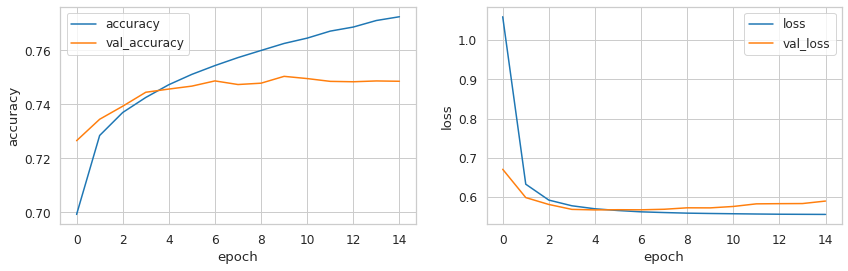

In [ ]:
plot_history(fit)

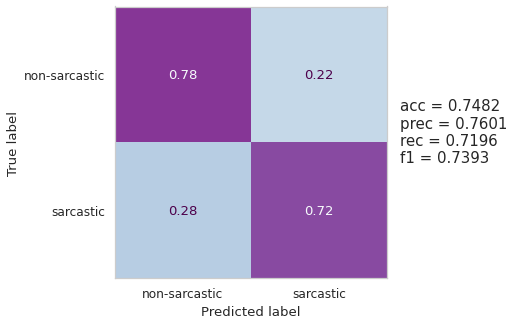

In [ ]:
evaluate(model, X_test['comment'].values, y_test)

## CNN

In [ ]:
def build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix, reg=5e-6, k=(2,3)):
    model = Sequential([
        Input(shape=(1,), dtype=tf.string),
        tokenizer_layer,
        Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                mask_zero=True, weights=[emb_matrix], trainable=True,
                embeddings_regularizer=L1L2(l1=reg, l2=reg)),

        Conv1D(64, k[0], activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv1D(64, k[0], activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2, padding='same'),
        Dropout(0.3),

        Conv1D(128, k[1], activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        Conv1D(128, k[1], activation='relu', kernel_initializer='he_normal', padding='same'),
        BatchNormalization(),
        
        GlobalMaxPooling1D(),
        Dense(100, activation='relu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
model = build_seq_cnn(input_dim, vec_len, maxlen, emb_matrix_comment, reg=3e-6, k=(2,3))

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 140s 23ms/step - loss: 1.4829 - bc: 0.5893 - accuracy: 0.6857 - val_loss: 0.8451 - val_bc: 0.5496 - val_accuracy: 0.7217
Epoch 2/50
5643/5643 [==============================] - 130s 23ms/step - loss: 0.7186 - bc: 0.5432 - accuracy: 0.7264 - val_loss: 0.6502 - val_bc: 0.5376 - val_accuracy: 0.7275
Epoch 3/50
5643/5643 [==============================] - 129s 23ms/step - loss: 0.6267 - bc: 0.5328 - accuracy: 0.7343 - val_loss: 0.6061 - val_bc: 0.5278 - val_accuracy: 0.7341
Epoch 4/50
5643/5643 [==============================] - 130s 23ms/step - loss: 0.5990 - bc: 0.5264 - accuracy: 0.7382 - val_loss: 0.5899 - val_bc: 0.5243 - val_accuracy: 0.7373
Epoch 5/50
5643/5643 [==============================] - 130s 23ms/step - loss: 0.5859 - bc: 0.5209 - accuracy: 0.7423 - val_loss: 0.5833 - val_bc: 0.5223 - val_accuracy: 0.7381
Epoch 6/50
5643/5643 [==============================] - 126s 22ms/step - loss: 0.5782 - bc: 0.5161 - accuracy: 0.74

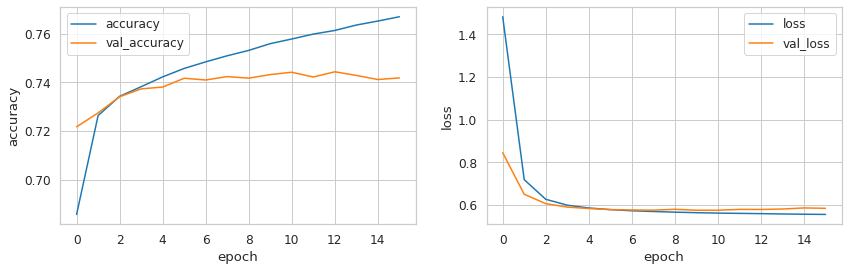

In [ ]:
plot_history(fit)

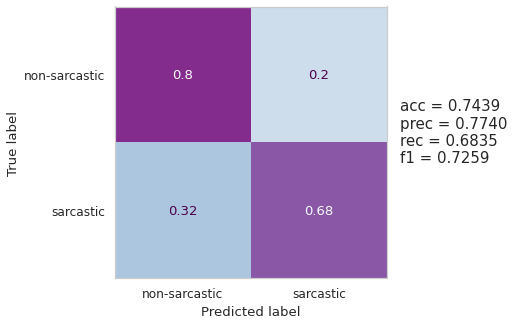

In [ ]:
evaluate(model, X_test['comment'], y_test)

## CNN-LSTM-DNN

In [ ]:
model = Sequential([
    Input(shape=(1,), dtype=tf.string),
    tokenizer_layer,
    Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
              mask_zero=True, weights=[emb_matrix_comment], trainable=True,
              embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6)),
    Conv1D(64, 2, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv1D(128, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    LSTM(100, dropout=0.25, return_sequences=True),
    LSTM(100, dropout=0.25),
    Dense(50, activation='relu', kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 192s 33ms/step - loss: 1.0685 - bc: 0.5595 - accuracy: 0.7103 - val_loss: 0.7098 - val_bc: 0.5369 - val_accuracy: 0.7283
Epoch 2/50
5643/5643 [==============================] - 187s 33ms/step - loss: 0.6555 - bc: 0.5311 - accuracy: 0.7331 - val_loss: 0.6234 - val_bc: 0.5290 - val_accuracy: 0.7345
Epoch 3/50
5643/5643 [==============================] - 187s 33ms/step - loss: 0.6056 - bc: 0.5221 - accuracy: 0.7397 - val_loss: 0.5960 - val_bc: 0.5228 - val_accuracy: 0.7381
Epoch 4/50
5643/5643 [==============================] - 189s 33ms/step - loss: 0.5854 - bc: 0.5150 - accuracy: 0.7448 - val_loss: 0.5868 - val_bc: 0.5220 - val_accuracy: 0.7390
Epoch 5/50
5643/5643 [==============================] - 182s 32ms/step - loss: 0.5751 - bc: 0.5098 - accuracy: 0.7480 - val_loss: 0.5795 - val_bc: 0.5172 - val_accuracy: 0.7420
Epoch 6/50
5643/5643 [==============================] - 181s 32ms/step - loss: 0.5685 - bc: 0.5053 - accuracy: 0.75

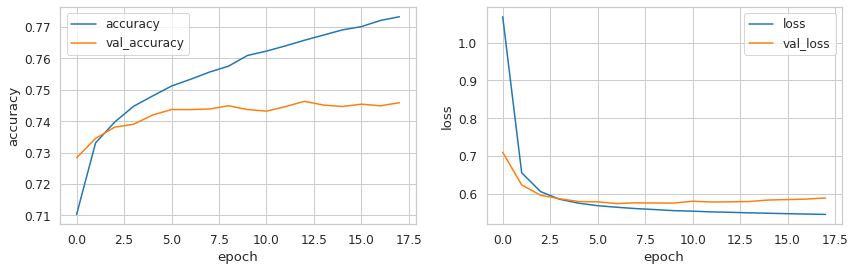

In [ ]:
plot_history(fit)

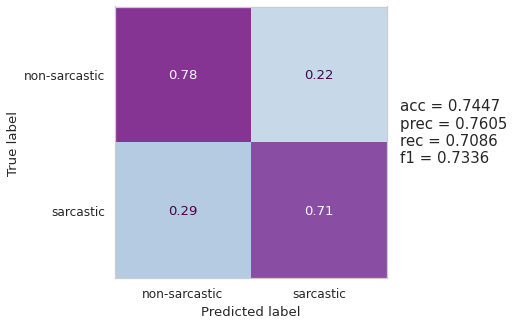

In [ ]:
evaluate(model, X_test['comment'].values, y_test)

## MHA: self-attention

In [15]:
input_layer = keras.Input(shape=(1,), dtype=tf.string)
tokenize_comment = tokenizer_layer(input_layer)

emb_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                      mask_zero=True, weights=[emb_matrix_comment], trainable=True,
                      embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))

embeddings = emb_layer(tokenize_comment)

mask = emb_layer.compute_mask(tokenize_comment)[:, tf.newaxis]

gru = GRU(100, dropout=0.3)(embeddings)
mha, _ = MultiHeadAttention(3, 64, name='attention')(embeddings, embeddings,
                                                     attention_mask=mask, return_attention_scores=True)
mha = GlobalMaxPooling1D()(mha)

x = Concatenate()([gru, mha])

x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[input_layer], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 189s 32ms/step - loss: 1.0511 - bc: 0.5730 - accuracy: 0.7013 - val_loss: 0.6901 - val_bc: 0.5466 - val_accuracy: 0.7207
Epoch 2/50
5643/5643 [==============================] - 176s 31ms/step - loss: 0.6414 - bc: 0.5410 - accuracy: 0.7271 - val_loss: 0.6073 - val_bc: 0.5320 - val_accuracy: 0.7318
Epoch 3/50
5643/5643 [==============================] - 194s 34ms/step - loss: 0.5971 - bc: 0.5298 - accuracy: 0.7350 - val_loss: 0.5912 - val_bc: 0.5308 - val_accuracy: 0.7318
Epoch 4/50
5643/5643 [==============================] - 180s 32ms/step - loss: 0.5803 - bc: 0.5218 - accuracy: 0.7410 - val_loss: 0.5748 - val_bc: 0.5195 - val_accuracy: 0.7392
Epoch 5/50
5643/5643 [==============================] - 176s 31ms/step - loss: 0.5716 - bc: 0.5157 - accuracy: 0.7449 - val_loss: 0.5705 - val_bc: 0.5166 - val_accuracy: 0.7422
Epoch 6/50
5643/5643 [==============================] - 178s 32ms/step - loss: 0.5661 - bc: 0.5103 - accuracy: 0.74

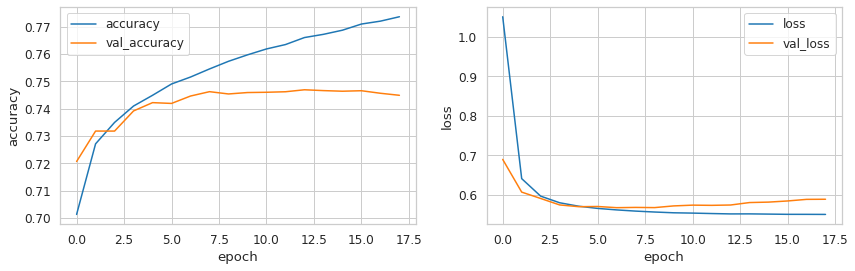

In [19]:
plot_history(fit)

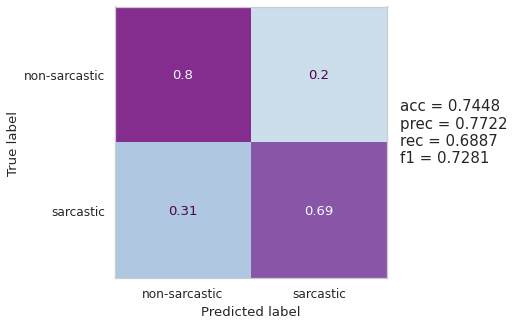

In [20]:
evaluate(model, X_test['comment'].values, y_test)

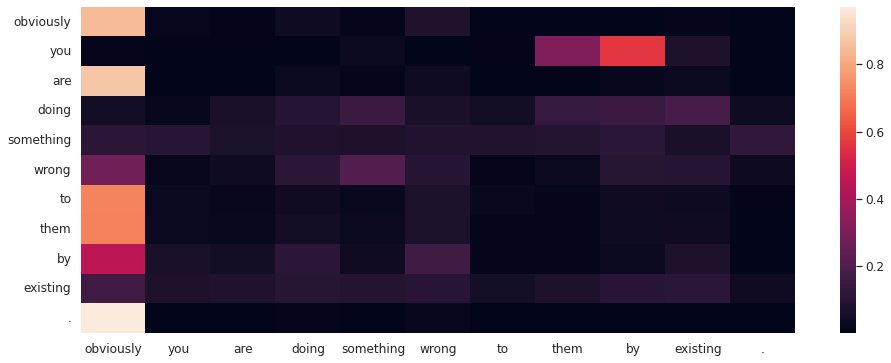

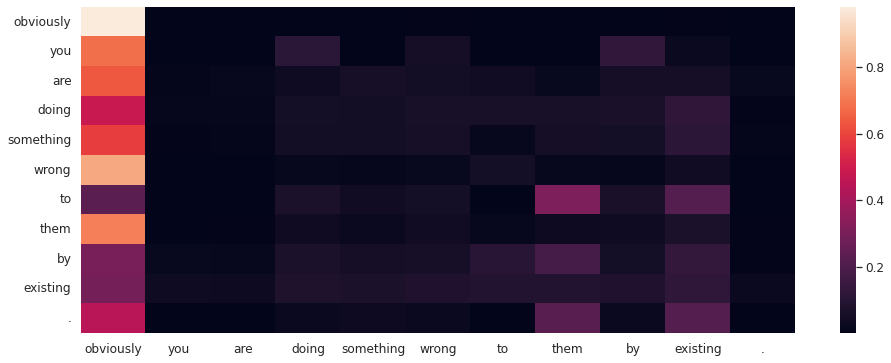

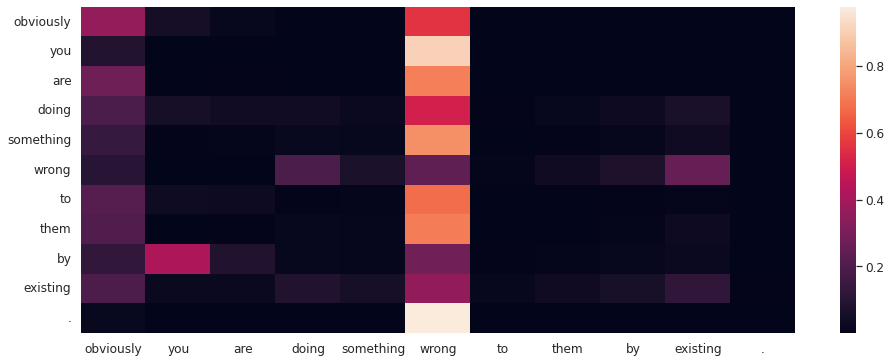

In [23]:
plot_attention_scores(model, X_train['comment'].sample(1).values)

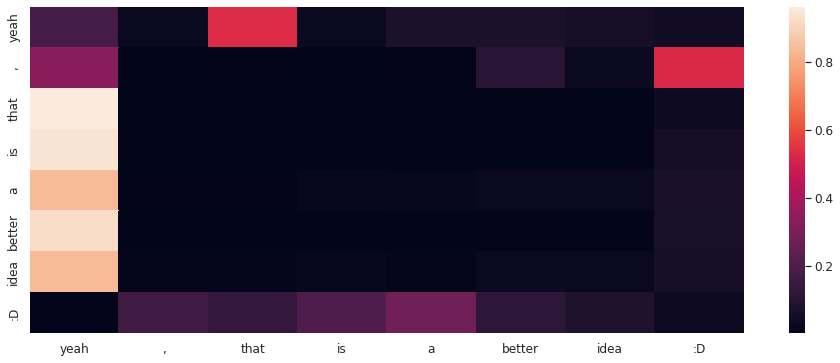

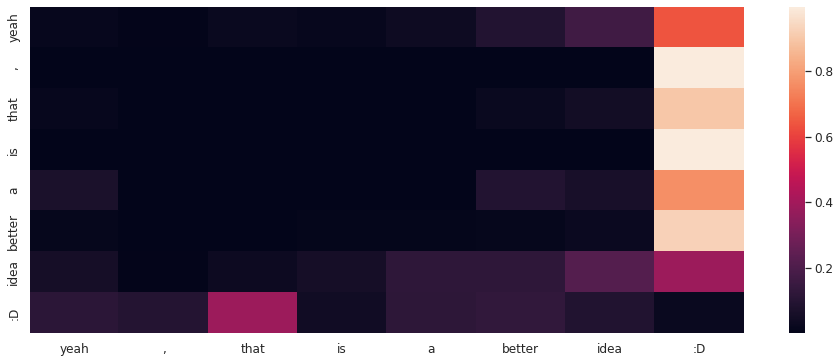

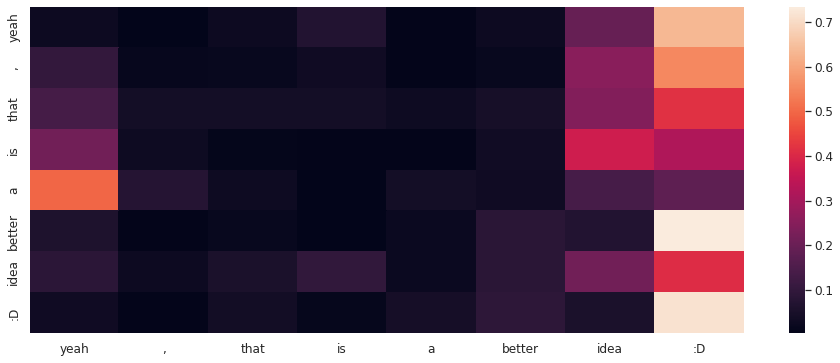

In [21]:
plot_attention_scores(model, X_train['comment'].sample(1).values)

In [ ]:
input_layer = keras.Input(shape=(1,), dtype=tf.string)
tokenize_comment = tokenizer_layer(input_layer)

emb_layer = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                      mask_zero=True, weights=[emb_matrix_comment], trainable=True,
                      embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))

embeddings = emb_layer(tokenize_comment)
mask = emb_layer.compute_mask(tokenize_comment)[:, tf.newaxis]

gru = Bidirectional(GRU(100, dropout=0.3, return_sequences=True))(embeddings)
mha, _ = MultiHeadAttention(3, 64, name='attention')(gru, gru, attention_mask=mask,
                                                     return_attention_scores=True)
x = GlobalMaxPooling1D()(mha)

x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[input_layer], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(X_train['comment'], y_train, batch_size=128, epochs=50, callbacks=[es],
                validation_data=(X_val['comment'], y_val))

Epoch 1/50
5643/5643 [==============================] - 156s 26ms/step - loss: 1.0186 - bc: 0.5662 - accuracy: 0.7057 - val_loss: 0.6925 - val_bc: 0.5605 - val_accuracy: 0.7044
Epoch 2/50
5643/5643 [==============================] - 145s 26ms/step - loss: 0.6324 - bc: 0.5369 - accuracy: 0.7301 - val_loss: 0.6020 - val_bc: 0.5273 - val_accuracy: 0.7350
Epoch 3/50
5643/5643 [==============================] - 147s 26ms/step - loss: 0.5942 - bc: 0.5268 - accuracy: 0.7369 - val_loss: 0.5816 - val_bc: 0.5204 - val_accuracy: 0.7405
Epoch 4/50
5643/5643 [==============================] - 148s 26ms/step - loss: 0.5794 - bc: 0.5187 - accuracy: 0.7420 - val_loss: 0.5732 - val_bc: 0.5152 - val_accuracy: 0.7438
Epoch 5/50
5643/5643 [==============================] - 146s 26ms/step - loss: 0.5722 - bc: 0.5129 - accuracy: 0.7467 - val_loss: 0.5694 - val_bc: 0.5121 - val_accuracy: 0.7451
Epoch 6/50
5643/5643 [==============================] - 145s 26ms/step - loss: 0.5675 - bc: 0.5073 - accuracy: 0.75

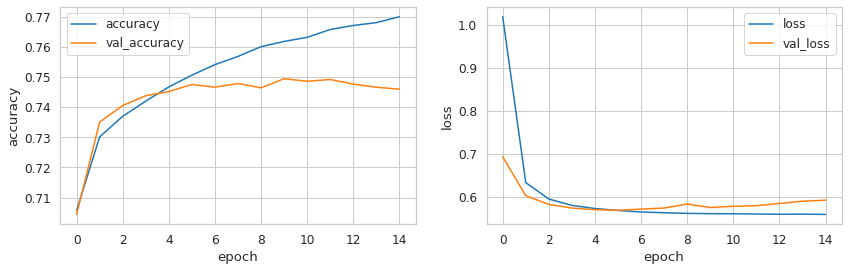

In [ ]:
plot_history(fit)

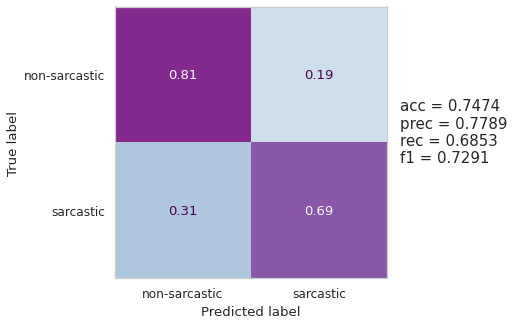

In [ ]:
evaluate(model, X_test['comment'].values, y_test)

# context

In [ ]:
vocab_com, vocab_par = tokenizer_layer.get_vocabulary(), tokenizer_par_layer.get_vocabulary()

In [ ]:
vec_len = 100
wordemb = WordEmbeddings()
emb_matrix_comment = wordemb.get_glove_embeddings(input_dim, vec_len, vocab_com, root=root)
emb_matrix_parent = wordemb.get_glove_embeddings(input_dim, vec_len, vocab_par, root=root)

coverage: 0.9810
coverage: 0.9889


In [ ]:
train_data = {'comment': X_train['comment'].values, 'parent': X_train['parent'].values}
val_data = {'comment': X_val['comment'].values, 'parent': X_val['parent'].values}
test_data = {'comment': X_test['comment'].values, 'parent': X_test['parent'].values}

## GRU + GRU

In [ ]:
def build_rnn(tok_layer, embedding_matrix, maxlen, reg=1e-6, bi=False):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)
    if bi:
        x = Bidirectional(GRU(100, dropout=0.3))(x)
    else:
        x = GRU(100, dropout=0.3)(x)

    return x

In [ ]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_rnn = build_rnn(tokenize_comment, emb_matrix_comment, maxlen, reg=3e-6)
parent_rnn = build_rnn(tokenize_parent, emb_matrix_parent, maxlen_par, reg=3e-6)

x = Concatenate()([comment_rnn, parent_rnn])
x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_data, y_train, epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, y_val))

Epoch 1/50
5643/5643 [==============================] - 194s 32ms/step - loss: 1.3249 - bc: 0.5746 - accuracy: 0.6984 - val_loss: 0.6810 - val_bc: 0.5377 - val_accuracy: 0.7266
Epoch 2/50
5643/5643 [==============================] - 181s 32ms/step - loss: 0.6402 - bc: 0.5373 - accuracy: 0.7287 - val_loss: 0.6053 - val_bc: 0.5249 - val_accuracy: 0.7360
Epoch 3/50
5643/5643 [==============================] - 181s 32ms/step - loss: 0.6000 - bc: 0.5253 - accuracy: 0.7380 - val_loss: 0.5868 - val_bc: 0.5177 - val_accuracy: 0.7411
Epoch 4/50
5643/5643 [==============================] - 180s 32ms/step - loss: 0.5860 - bc: 0.5171 - accuracy: 0.7441 - val_loss: 0.5764 - val_bc: 0.5104 - val_accuracy: 0.7461
Epoch 5/50
5643/5643 [==============================] - 179s 32ms/step - loss: 0.5788 - bc: 0.5104 - accuracy: 0.7482 - val_loss: 0.5727 - val_bc: 0.5063 - val_accuracy: 0.7491
Epoch 6/50
5643/5643 [==============================] - 179s 32ms/step - loss: 0.5752 - bc: 0.5052 - accuracy: 0.75

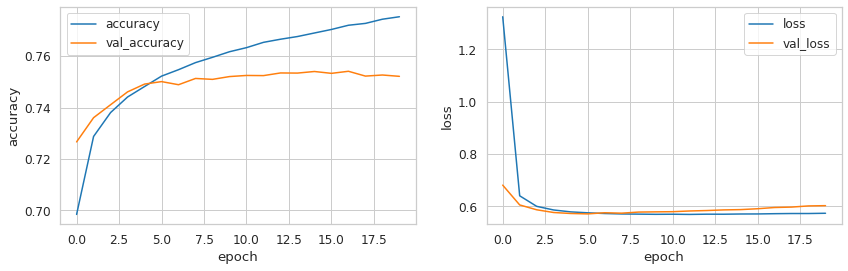

In [ ]:
plot_history(fit)

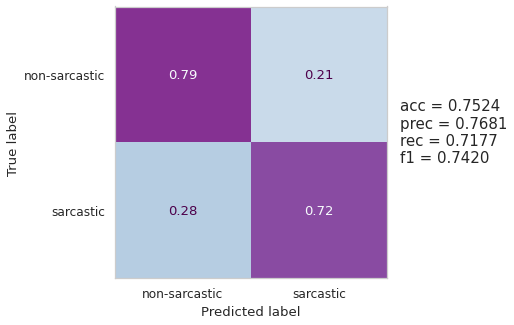

In [ ]:
evaluate(model, test_data, y_test)

## CNN + CNN

In [ ]:
def build_cnn(tok_layer, vec_len, maxlen, embedding_matrix, reg=1e-6):
    x = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                  mask_zero=True, weights=[embedding_matrix], trainable=True,
                  embeddings_regularizer=L1L2(l1=reg, l2=reg))(tok_layer)

    x = Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(64, 2, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalMaxPooling1D()(x)

    return x

In [ ]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_cnn = build_cnn(tokenize_comment, vec_len, maxlen, emb_matrix_comment, reg=5e-6)
parent_cnn = build_cnn(tokenize_parent, vec_len, maxlen_par, emb_matrix_parent, reg=5e-6)

x = Concatenate()([comment_cnn, parent_cnn])
x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_data, y_train, epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, y_val))

Epoch 1/50
5643/5643 [==============================] - 169s 28ms/step - loss: 2.4079 - bc: 0.5792 - accuracy: 0.6948 - val_loss: 0.7968 - val_bc: 0.5395 - val_accuracy: 0.7267
Epoch 2/50
5643/5643 [==============================] - 161s 29ms/step - loss: 0.7010 - bc: 0.5407 - accuracy: 0.7276 - val_loss: 0.6410 - val_bc: 0.5298 - val_accuracy: 0.7340
Epoch 3/50
5643/5643 [==============================] - 155s 27ms/step - loss: 0.6269 - bc: 0.5303 - accuracy: 0.7358 - val_loss: 0.6094 - val_bc: 0.5242 - val_accuracy: 0.7378
Epoch 4/50
5643/5643 [==============================] - 152s 27ms/step - loss: 0.6048 - bc: 0.5228 - accuracy: 0.7409 - val_loss: 0.5952 - val_bc: 0.5183 - val_accuracy: 0.7415
Epoch 5/50
5643/5643 [==============================] - 152s 27ms/step - loss: 0.5951 - bc: 0.5177 - accuracy: 0.7450 - val_loss: 0.5920 - val_bc: 0.5168 - val_accuracy: 0.7429
Epoch 6/50
5643/5643 [==============================] - 150s 27ms/step - loss: 0.5882 - bc: 0.5127 - accuracy: 0.74

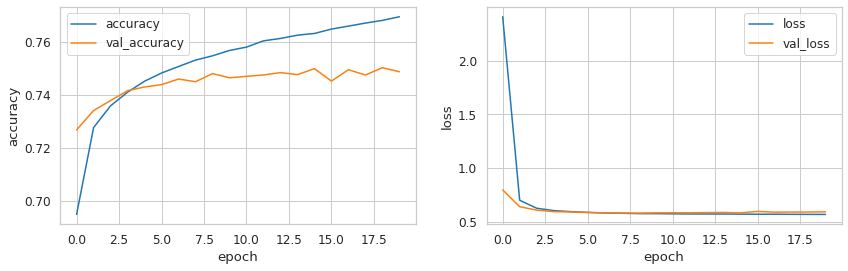

In [ ]:
plot_history(fit)

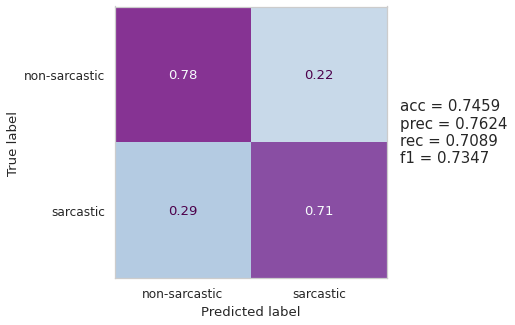

In [ ]:
evaluate(model, test_data, y_test)

## bi-GRU + CNN

In [ ]:
comment_input =  keras.Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = keras.Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

comment_rnn = build_rnn(tokenize_comment, vec_len, maxlen, emb_matrix_comment, reg=3e-6, bi=True)
parent_cnn = build_cnn(tokenize_parent, vec_len, maxlen_par, emb_matrix_parent, reg=5e-6)

x = Concatenate()([comment_rnn, parent_cnn])
x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_data, y_train, epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, y_val))

Epoch 1/50
5643/5643 [==============================] - 223s 38ms/step - loss: 1.9090 - bc: 0.5664 - accuracy: 0.7055 - val_loss: 0.7184 - val_bc: 0.5364 - val_accuracy: 0.7277
Epoch 2/50
5643/5643 [==============================] - 207s 37ms/step - loss: 0.6476 - bc: 0.5335 - accuracy: 0.7323 - val_loss: 0.6059 - val_bc: 0.5227 - val_accuracy: 0.7368
Epoch 3/50
5643/5643 [==============================] - 209s 37ms/step - loss: 0.5964 - bc: 0.5221 - accuracy: 0.7406 - val_loss: 0.5836 - val_bc: 0.5156 - val_accuracy: 0.7435
Epoch 4/50
5643/5643 [==============================] - 208s 37ms/step - loss: 0.5811 - bc: 0.5133 - accuracy: 0.7469 - val_loss: 0.5750 - val_bc: 0.5109 - val_accuracy: 0.7455
Epoch 5/50
5643/5643 [==============================] - 208s 37ms/step - loss: 0.5728 - bc: 0.5055 - accuracy: 0.7524 - val_loss: 0.5690 - val_bc: 0.5048 - val_accuracy: 0.7502
Epoch 6/50
5643/5643 [==============================] - 208s 37ms/step - loss: 0.5675 - bc: 0.4990 - accuracy: 0.75

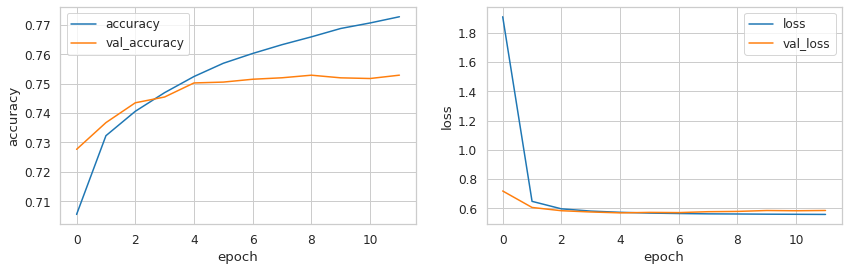

In [ ]:
plot_history(fit)

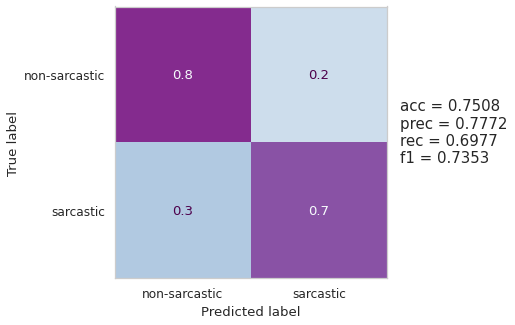

In [ ]:
evaluate(model, test_data, y_test)

## MHA: comment + parent

In [ ]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

emb_layer_com = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                          mask_zero=True, weights=[emb_matrix_comment], trainable=True,
                          embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))

emb_layer_par = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen_par,
                          mask_zero=True, weights=[emb_matrix_parent], trainable=True,
                          embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))

emb_comment = emb_layer_com(tokenize_comment)
emb_parent = emb_layer_par(tokenize_parent)

mask1 = tf.squeeze(emb_layer_com.compute_mask(tokenize_comment))
mask2 = tf.squeeze(emb_layer_par.compute_mask(tokenize_parent))
mask = tf.reshape(mask1, [-1, maxlen, 1]) & tf.reshape(mask2, [-1, 1, maxlen_par])

gru_comment = GRU(100, dropout=0.3)(emb_comment)
gru_parent = GRU(100, dropout=0.3)(emb_parent)
mha, _ = MultiHeadAttention(3, 64, name='attention')(emb_comment, emb_parent,
                                                     attention_mask=mask, return_attention_scores=True)
mha = GlobalMaxPooling1D()(mha)

x = Concatenate()([gru_comment, gru_parent, mha])

x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_data, y_train, epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, y_val))

Epoch 1/50
5643/5643 [==============================] - 212s 36ms/step - loss: 1.2998 - bc: 0.5705 - accuracy: 0.7023 - val_loss: 0.6865 - val_bc: 0.5389 - val_accuracy: 0.7255
Epoch 2/50
5643/5643 [==============================] - 200s 35ms/step - loss: 0.6459 - bc: 0.5361 - accuracy: 0.7303 - val_loss: 0.6130 - val_bc: 0.5245 - val_accuracy: 0.7370
Epoch 3/50
5643/5643 [==============================] - 199s 35ms/step - loss: 0.6066 - bc: 0.5253 - accuracy: 0.7388 - val_loss: 0.5894 - val_bc: 0.5154 - val_accuracy: 0.7425
Epoch 4/50
5643/5643 [==============================] - 198s 35ms/step - loss: 0.5932 - bc: 0.5165 - accuracy: 0.7444 - val_loss: 0.5862 - val_bc: 0.5114 - val_accuracy: 0.7450
Epoch 5/50
5643/5643 [==============================] - 198s 35ms/step - loss: 0.5864 - bc: 0.5094 - accuracy: 0.7499 - val_loss: 0.5851 - val_bc: 0.5115 - val_accuracy: 0.7454
Epoch 6/50
5643/5643 [==============================] - 198s 35ms/step - loss: 0.5823 - bc: 0.5038 - accuracy: 0.75

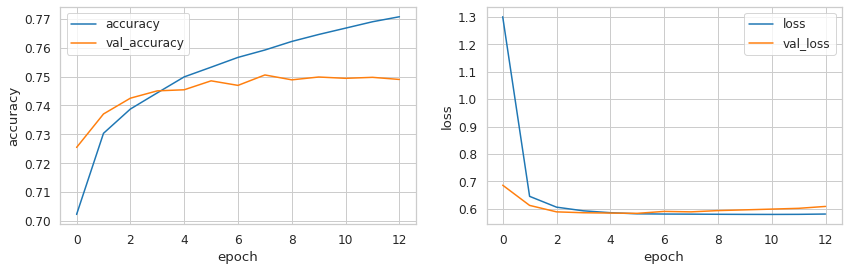

In [ ]:
plot_history(fit)

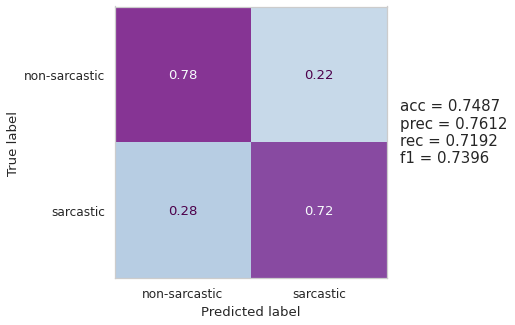

In [ ]:
evaluate(model, test_data, y_test)

## MHA: emotion comment + parent

In [ ]:
seed_words = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'good', 'bad']

In [ ]:
emotion_emb_com = get_emotion_embeddings(emb_matrix_comment, vocab_com, seed_words)
emotion_emb_par = get_emotion_embeddings(emb_matrix_parent, vocab_par, seed_words)

In [ ]:
comment_input =  Input(shape=(1,), name='comment', dtype=tf.string)
parent_input = Input(shape=(1,), name='parent', dtype=tf.string)

tokenize_comment = tokenizer_layer(comment_input)
tokenize_parent = tokenizer_par_layer(parent_input)

emb_layer_com = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen,
                          mask_zero=True, weights=[emb_matrix_comment], trainable=True,
                          embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))

emb_layer_par = Embedding(input_dim=input_dim, output_dim=vec_len, input_length=maxlen_par,
                          mask_zero=True, weights=[emb_matrix_parent], trainable=True,
                          embeddings_regularizer=L1L2(l1=3e-6, l2=3e-6))

emb_emo_layer_com = Embedding(input_dim=input_dim, output_dim=len(seed_words), input_length=maxlen,
                              mask_zero=True, weights=[emotion_emb_com], trainable=False)

emb_emo_layer_par = Embedding(input_dim=input_dim, output_dim=len(seed_words), input_length=maxlen,
                              mask_zero=True, weights=[emotion_emb_par], trainable=False)

emb_comment = emb_layer_com(tokenize_comment)
emb_parent = emb_layer_par(tokenize_parent)

emotion_comment = emb_emo_layer_com(tokenize_comment)
emotion_parent = emb_emo_layer_par(tokenize_parent)

mask1 = tf.squeeze(emb_emo_layer_com.compute_mask(tokenize_comment))
mask2 = tf.squeeze(emb_emo_layer_par.compute_mask(tokenize_parent))
mask = tf.reshape(mask1, [-1, maxlen, 1]) & tf.reshape(mask2, [-1, 1, maxlen_par])

gru_comment = GRU(100, dropout=0.3)(emb_comment)
gru_parent = GRU(100, dropout=0.3)(emb_parent)
mha, _ = MultiHeadAttention(3, 64, name='attention')(emotion_comment, emotion_parent,
                                                      attention_mask=mask, return_attention_scores=True)
mha = GlobalMaxPooling1D()(mha)

x = Concatenate()([gru_comment, gru_parent, mha])

x = Dense(100, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

binary_crossentropy = tf.keras.losses.BinaryCrossentropy(name='bc')
es = EarlyStopping(monitor='val_bc', min_delta=1e-5, patience=5, restore_best_weights=True)

model = keras.Model(inputs=[comment_input, parent_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[binary_crossentropy, 'accuracy'])
fit = model.fit(train_data, y_train, epochs=50, batch_size=128, callbacks=[es],
                validation_data=(val_data, y_val))

Epoch 1/50
5643/5643 [==============================] - 209s 36ms/step - loss: 1.3296 - bc: 0.5746 - accuracy: 0.6982 - val_loss: 0.7018 - val_bc: 0.5582 - val_accuracy: 0.7070
Epoch 2/50
5643/5643 [==============================] - 198s 35ms/step - loss: 0.6379 - bc: 0.5366 - accuracy: 0.7298 - val_loss: 0.6035 - val_bc: 0.5246 - val_accuracy: 0.7364
Epoch 3/50
5643/5643 [==============================] - 198s 35ms/step - loss: 0.5982 - bc: 0.5255 - accuracy: 0.7380 - val_loss: 0.5851 - val_bc: 0.5169 - val_accuracy: 0.7423
Epoch 4/50
5643/5643 [==============================] - 197s 35ms/step - loss: 0.5845 - bc: 0.5168 - accuracy: 0.7445 - val_loss: 0.5779 - val_bc: 0.5119 - val_accuracy: 0.7468
Epoch 5/50
5643/5643 [==============================] - 196s 35ms/step - loss: 0.5781 - bc: 0.5106 - accuracy: 0.7488 - val_loss: 0.5736 - val_bc: 0.5072 - val_accuracy: 0.7483
Epoch 6/50
5643/5643 [==============================] - 197s 35ms/step - loss: 0.5748 - bc: 0.5054 - accuracy: 0.75

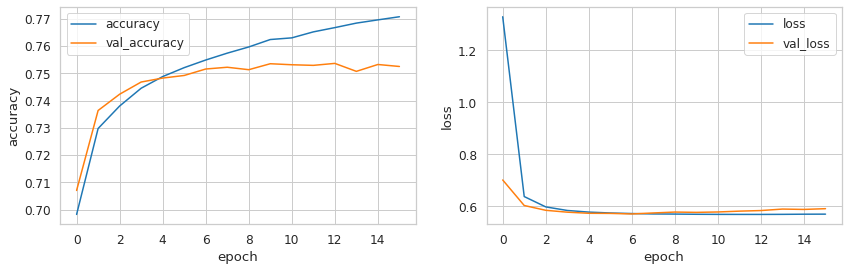

In [ ]:
plot_history(fit)

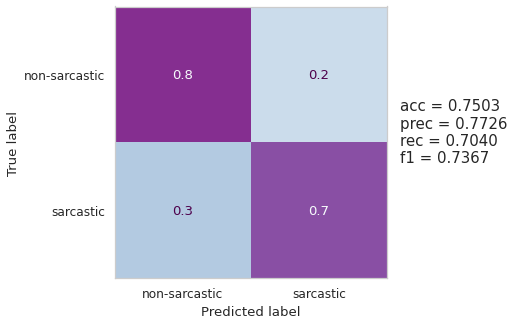

In [ ]:
evaluate(model, test_data, y_test)